In [1]:
import pandas as pd
import numpy as np
# import pyodbc
# from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
# from skopt import forest_minimize
from skopt.space import Integer, Real
import joblib
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [2]:
df = pd.read_csv("Pulsar.csv")

In [3]:
df.head()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [4]:
df["Class"].value_counts()

Class
0    16259
1     1639
Name: count, dtype: int64

In [5]:
# Mostrar la información completa del DataFrame
df.dtypes

Mean_Integrated         float64
SD                      float64
EK                      float64
Skewness                float64
Mean_DMSNR_Curve        float64
SD_DMSNR_Curve          float64
EK_DMSNR_Curve          float64
Skewness_DMSNR_Curve    float64
Class                     int64
dtype: object

In [6]:
df.isnull().sum()

Mean_Integrated         0
SD                      0
EK                      0
Skewness                0
Mean_DMSNR_Curve        0
SD_DMSNR_Curve          0
EK_DMSNR_Curve          0
Skewness_DMSNR_Curve    0
Class                   0
dtype: int64

In [7]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
df.describe()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309330,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392141,110.642211,34.539844,1191.000837,1.000000


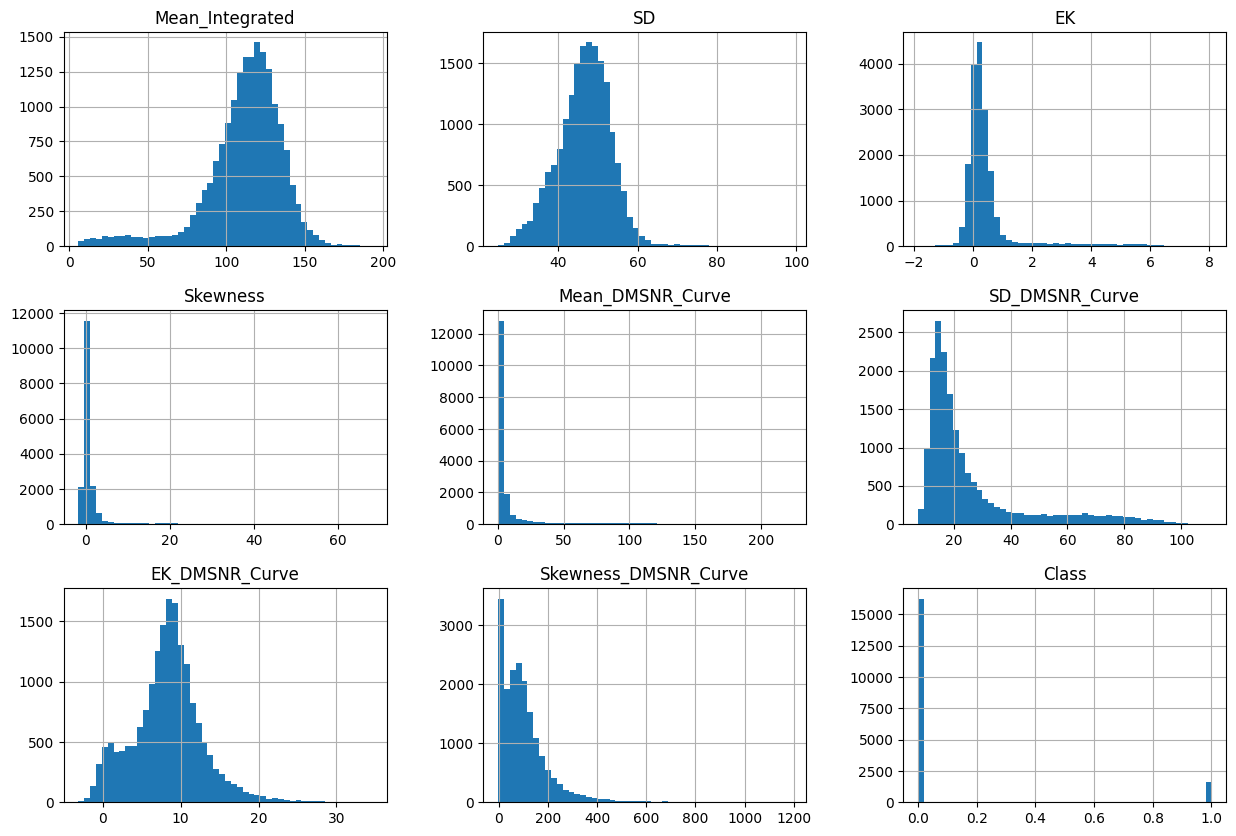

In [8]:
df.hist(bins=50, figsize= (15, 10))
plt.show()

In [9]:
X = df.iloc[:,:-1]
X

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306
...,...,...,...,...,...,...,...,...
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910


In [10]:
Y = df.iloc[:,-1]
Y

0        0
1        0
2        0
3        0
4        0
        ..
17893    0
17894    0
17895    0
17896    0
17897    0
Name: Class, Length: 17898, dtype: int64

In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, stratify= Y, random_state = 45)

In [12]:
mmscaler = MinMaxScaler()

In [13]:
# X_train = mmscaler.fit_transform(X_train)
# X_train

In [14]:
# X_test = mmscaler.fit_transform(X_test)

In [15]:
# space_xg ={'max_depth': hp.quniform("max_depth", 3, 18, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#         'n_estimators': 180,
#         'seed': 42
#     }

In [16]:
# def objective(space_xg):
#     clf=xgb.XGBClassifier(
#                     n_estimators =space_xg['n_estimators'], max_depth = int(space_xg['max_depth']), gamma = space_xg['gamma'],
#                     reg_alpha = int(space_xg['reg_alpha']),min_child_weight=int(space_xg['min_child_weight']))
    
#     evaluation = [( X_train, Y_train), ( X_test, Y_test)]
    
#     clf.fit(X_train, Y_train,
#             eval_set=evaluation, eval_metric="auc",
#             early_stopping_rounds=10,verbose=False)
    

#     pred = clf.predict(X_test)
#     recall = recall_score(Y_test, pred>0.5)
#     print ("SCORE:", recall)
#     return {'loss': -recall, 'status': STATUS_OK }

In [17]:
# trials = Trials()

# best_hyperparams = fmin(fn = objective,
#                         space = space_xg,
#                         algo = tpe.suggest,
#                         max_evals = 100,
#                         trials = trials)

In [18]:
# print("The best hyperparameters are : ","\n")
# print(best_hyperparams)

In [19]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, Y_train)

c:\Users\GGudino\OneDrive - COA S.A\Documentos\GitHub\pulsar_classification\venv\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\GGudino\OneDrive - COA S.A\Documentos\GitHub\pulsar_classification\venv\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\GGudino\OneDrive - COA S.A\Documentos\GitHub\pulsar_classification\venv\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\GGudino\OneDrive - COA S.A\Documentos\GitHub\pulsar_classification\venv\Lib\site-packages\xgboost\data.py:3

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [20]:
y_train_pred_xg = xgb_model.predict(X_train)

print(confusion_matrix(Y_train, y_train_pred_xg))

[[11380     1]
 [   10  1137]]


c:\Users\GGudino\OneDrive - COA S.A\Documentos\GitHub\pulsar_classification\venv\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\GGudino\OneDrive - COA S.A\Documentos\GitHub\pulsar_classification\venv\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\GGudino\OneDrive - COA S.A\Documentos\GitHub\pulsar_classification\venv\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\GGudino\OneDrive - COA S.A\Documentos\GitHub\pulsar_classification\venv\Lib\site-packages\xgboost\data.py:3

In [21]:
y_pred_xg = xgb_model.predict(X_test)

print(confusion_matrix(Y_test, y_pred_xg))

[[4832   46]
 [  68  424]]


c:\Users\GGudino\OneDrive - COA S.A\Documentos\GitHub\pulsar_classification\venv\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\GGudino\OneDrive - COA S.A\Documentos\GitHub\pulsar_classification\venv\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\GGudino\OneDrive - COA S.A\Documentos\GitHub\pulsar_classification\venv\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\GGudino\OneDrive - COA S.A\Documentos\GitHub\pulsar_classification\venv\Lib\site-packages\xgboost\data.py:3

In [22]:
# Calcula las métricas en tu conjunto de prueba
accuracy = accuracy_score(Y_test, y_pred_xg)
precision = precision_score(Y_test, y_pred_xg)
recall = recall_score(Y_test, y_pred_xg)
f1 = f1_score(Y_test, y_pred_xg)

# Imprime las métricas
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.98
Precision: 0.90
Recall: 0.86
F1 Score: 0.88


In [23]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

In [24]:
len(Y_train)

12528

In [25]:
Y_train

3216     0
4690     0
6408     0
6636     0
1587     0
        ..
16323    1
6205     0
9624     0
1251     0
878      0
Name: Class, Length: 12528, dtype: int64

In [53]:
z = np.array(Y_train).reshape((-1,1))

(12528, 1)

In [55]:
zz = np.array(y_train_pred_xg).reshape(-1,1)

In [57]:
fpr_train, tpr_train  = roc_curve(z, zz)
roc_auc_train_xg = auc(fpr_train, tpr_train)

ValueError: too many values to unpack (expected 2)

In [28]:
fpr_test, tpr_test  = roc_curve(Y_test, y_pred_xg[:,1])
roc_auc_test_svc = auc(fpr_test, tpr_test)
plt.figure(figsize =(12, 7))
lw=1

plt.plot(fpr_train, tpr_train, color="darkred", lw=lw, label="SVM Train ROC curve (area = %0.2f)" % roc_auc_train_svc)
plt.plot(fpr_test, tpr_test, color="red", lw=lw, label="SVM Test ROC curve (area = %0.2f)" % roc_auc_test_svc)


plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [67]:
# rfc = RandomForestClassifier(random_state=42)

In [68]:
# rfc.fit(x_train, y_train)

In [69]:
# y_train_predict = cross_val_predict(rfc, x_train, y_train, cv=10)

In [70]:
# confusion_matrix(y_train, y_train_predict)

In [71]:
# def objective(params):
#     n_estimators, max_depth, min_samples_split,min_samples_leaf, max_features = params

#     model = RandomForestClassifier(
#         n_estimators=int(n_estimators),
#         max_depth=int(max_depth),
#         min_samples_split=int(min_samples_split),
#         min_samples_leaf=int(min_samples_leaf),
#         max_features=Real(max_features),
#         random_state=42
#     )

#     # Calcula el F1-score utilizando validación cruzada
#     scores = cross_val_score(model, x_train, y_train, cv=10, scoring='f1_macro')
#     # Retorna la negación del F1-score macro promedio, ya que forest_minimize busca minimizar la función objetivo
#     return -scores.mean()

In [72]:
# # space = [
# #     Integer(10, 200, name='n_estimators'),
# #     Integer(1, 32, name='max_depth'),
# #     Integer(2, 20, name='min_samples_split')
# # ]

# space = [
#     Integer(10, 200, name='n_estimators'),           # Número de árboles en el bosque
#     Integer(1, 32, name='max_depth'),               # Profundidad máxima de los árboles
#     Integer(2, 20, name='min_samples_split'),       # Número mínimo de muestras requeridas para dividir un nodo interno
#     Integer(1, 20, name='min_samples_leaf'),        # Número mínimo de muestras requeridas en un nodo hoja
#     Real(0.1, 1.0, name='max_features', prior='uniform'),  # Máximo número de características a considerar en cada división
# ]

In [73]:
# try:
#     result = joblib.load('results/optimization_results.pkl')
# except FileNotFoundError:
#     result = None

# # Si no hay resultados previos, inicia una nueva optimización
# if result is None:
#     result = gp_minimize(objective, space, n_calls=100, random_state=42)

# # Caso contrario, continúa la optimización desde donde se quedó
# else:
#     result = gp_minimize(objective, space, n_calls=100, random_state=42, callback=[result])

# # Guarda los resultados obtenidos
# joblib.dump(result, 'optimization_results.pkl')

# # Los resultados finales están en result
# print("Mejor conjunto de hiperparámetros encontrado:")
# print(result.x)
# print("Mejor valor de la métrica objetivo:")
# print(result.fun)

In [74]:
# result = forest_minimize(objective, space, n_calls=100, random_state=42)


In [75]:
# best_params = {
#     'n_estimators': int(result.x[0]),
#     'max_depth': int(result.x[1]),
#     'min_samples_split': int(result.x[2]),
#     'min_samples_leaf': int(result.x[3]),
#     'max_features':result.x[4]
# }

In [76]:
# result

In [77]:
# joblib.dump(result, 'results/optimization_results.pkl')

Bayesian Optimization
Bayesian Optimization uses probability to find the minimum of a function. The aim of this algorithm is to find the input value to a function which gives us the lowest possible output value. It usually performs better than the above methods and provides better performance in the testing phase and reduced optimization time. We can work with Bayesian optimization with the help of the Hyperopt library in python.

We can implement with 3 main parameters to the function fmin:

Objective Function: defines the loss function to minimize
Domain Space: defines the range of input values to test (in Bayesian Optimization, this space creates a probability distribution for each of the used Hyperparameters)
Optimization Algorithm: defines the search algorithm to select the best input values in each new iteration (Random Search, TPE, Adaptive TPE)

In [78]:
# from hyperopt import hp,fmin,tpe,STATUS_OK,Trials

# # space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
# #         'max_depth': hp.quniform('max_depth', 1, 100, 1),
# #         'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
# #         'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
# #         'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
# #         'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200,1300,1500])
# #     }
# space = {
#     'criterion': hp.choice('criterion', ['gini', 'entropy']),
#     'max_depth': hp.quniform('max_depth', 1, 50, 1),  # Change the range as needed
#     'max_features': hp.choice('max_features', ['auto', 'sqrt']),
#     'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
#     'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
#     'n_estimators': hp.quniform('n_estimators', 50, 200, 10),  # Adjust the range
# }


# def objective(space):
#     model = RandomForestClassifier(criterion = space['criterion'], max_depth = space['max_depth'],
#                                  max_features = space['max_features'],
#                                  min_samples_leaf = space['min_samples_leaf'],
#                                  min_samples_split = space['min_samples_split'],
#                                  n_estimators = space['n_estimators'], 
#                                  )
    
#     accuracy = cross_val_score(model, x_train, y_train, cv = 10).mean()

#     # We aim to maximize accuracy, therefore we return it as a negative value
#     return {'loss': -accuracy, 'status': STATUS_OK }

After defining objective function and domain space, we will call it in to fmin function.

In [79]:
# from sklearn.model_selection import cross_val_score
# trials = Trials()
# best = fmin(fn= objective,
#             space= space,
#             algo= tpe.suggest,
#             max_evals = 80,
#             trials= trials)
# best

For the result, best will return an index for each parameter that we have defined in space. So, we can refer to space to see the real value instead of index.

In [80]:
# result.fun

In [81]:
best_model = RandomForestClassifier( random_state=42) #**best_params,
best_model.fit(x_train, y_train)


RandomForestClassifier(random_state=42)

In [82]:
y_pred = best_model.predict(x_test)

In [83]:
# Calcula las métricas en tu conjunto de prueba
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprime las métricas
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.95
Precision: 0.76
Recall: 0.07
F1 Score: 0.14


In [84]:
confusion_matrix(y_test, y_pred)

array([[35878,    45],
       [ 1746,   140]], dtype=int64)

In [85]:
feature_importance = best_model.feature_importances_
feature_importance

array([1.01564313e-01, 1.13916475e-02, 3.34593988e-02, 1.86244770e-02,
       1.11175991e-02, 1.71830232e-02, 2.77247083e-02, 1.45880526e-02,
       9.24314872e-03, 4.60774322e-02, 1.94960704e-02, 1.72236372e-02,
       1.60726615e-02, 0.00000000e+00, 0.00000000e+00, 1.39670861e-02,
       3.45285901e-02, 0.00000000e+00, 1.40919798e-03, 1.95451842e-02,
       5.69297375e-03, 2.83013964e-09, 1.25940638e-02, 2.39895070e-03,
       2.02094063e-02, 6.13293407e-04, 0.00000000e+00, 6.88137245e-04,
       1.63951387e-03, 1.06361843e-02, 2.89429931e-03, 6.38322453e-03,
       3.02809182e-06, 1.58770241e-02, 1.02705349e-02, 1.73774812e-02,
       3.22132872e-07, 1.22526493e-02, 5.22277096e-03, 2.87122851e-03,
       1.15172203e-05, 2.09396023e-02, 6.47644158e-03, 3.85106591e-03,
       2.09933018e-02, 1.61795491e-03, 0.00000000e+00, 1.62721407e-03,
       2.29376126e-04, 7.13111980e-03, 3.10953405e-04, 1.42288539e-03,
       0.00000000e+00, 9.94171660e-04, 1.78513662e-03, 0.00000000e+00,
      

In [86]:
# Crea un DataFrame para relacionar características e importancias
feature_importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': feature_importance})

# Ordena las características por importancia en orden descendente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [87]:
feature_importance_df.head(15)

,Feature,Importance
0,cantTrab,0.101564
9,StroAccLab,0.046077
16,RegConBaja,0.034529
2,sexoMasc,0.033459
122,TiempoAltaMyr10dias,0.029580
6,Edad31_60,0.027725
84,Contusiones,0.025253
115,DistensionMuscular,0.024479
125,secuelasincapacitantes,0.023267
126,OcurrenciaViaPublica,0.021445
